# MIMIC-IV 

This is the notebook containing all the sql code we queried on Google BigQuery, the python code in particular for single-column-analysis, and the notes about the results we obtained. 

For the analysis of MIMIC-IV, we focus on the modules 'hosp' and 'icu'.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
%run textColumn_analysis.ipynb

## Overview of the data

|  | Value |
| --- | ----------- |
| Number of ICU stays (one patient can go through several ICUs) | 94 458 |
| Number of distinct hospital admissions$^*$ | 85 242 |
| Number of distinct ICU patients | 65 366 |

$^*$one patient can be admitted several times into the hospital. Here we only include hospital admissions that are associated with an ICU stay.

In [ ]:
%sql

# number of icu stays
SELECT COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.icustays` ;

# number of distinct hospital admission associated with icu stays
SELECT COUNT(DISTINCT hadm_id) FROM `physionet-data.mimiciv_3_1_icu.icustays`

# number of distinct patients in ICU
SELECT COUNT(DISTINCT subject_id) FROM `physionet-data.mimiciv_3_1_icu.icustays`

The following query allows to count the number of ICU related hospital admissions per patient. In total, **11 743** patients were admitted several times to hospital and received intensive care. the number of admissions ranges from 1 to 36.

In [ ]:
% sql

SELECT subject_id, COUNT(*) AS count_stays FROM
  (SELECT subject_id, hadm_id, COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.icustays`
    GROUP BY subject_id, hadm_id
    ORDER BY subject_id) AS patientsICUstays
GROUP BY subject_id
ORDER BY subject_id

During one hospital admission, a same patient can go through several intensive care units (ICUs). The following query account for the number of ICU units visited by patients during each of their stay.

In [ ]:
% sql 

SELECT subject_id, hadm_id, COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.icustays`
GROUP BY subject_id, hadm_id
ORDER BY subject_id

- average length of stay in an ICU (not in hospital) is **3.63** fractional days, that is, 3 days and 15 hours

In [ ]:
% sql

# temporary table with all patients that were in ICU
CREATE TEMPORARY TABLE ICUpatients AS (
  SELECT P.subject_id, P.gender, P.anchor_age, P.anchor_year, P.anchor_year_group, P.dod,
  S.hadm_id, S.stay_id, S.los
  FROM `physionet-data.mimiciv_3_1_icu.icustays` S
  JOIN `physionet-data.mimiciv_3_1_hosp.patients` P
  ON S.subject_id = P.subject_id
) ;

# average length of stay in an ICU 
SELECT AVG(los) FROM ICUpatients

## Patients representation
We look at patients in ICU only. The following query allows to identify the patients and the id of their admission in hospital, when it as associated with an ICU stay. We saved the result of this query as a table named _patientICUstays_ in Google BigQuery.

By joining the other tables to study on _patientICUstays_, we were able to extract the data related to ICU stays only (without always joining these tables on the _icustays_ table) and perform our analysis from there.

In [ ]:
% sql

SELECT subject_id, hadm_id FROM `physionet-data.mimiciv_3_1_icu.icustays`
  GROUP BY subject_id, hadm_id
  ORDER BY subject_id

**<center><u>We extract the ICU patient data from the _patients_ table (see following query) to study the profile of the patients in ICU).</u></center>**

**<u>Age</u>**

- age (`anchor_age`) of patients is always indicated, and ranges from **18** to **91** years old
- age average across distinct patients is **63.41**
- weighted average (_we count twice the age of a patient that was admitted twice into ICU_) is **63.00**

In [ ]:
% sql

SELECT *
FROM (SELECT DISTINCT subject_id FROM `iame-int.ICU.patientICUstays`) S
JOIN `physionet-data.mimiciv_3_1_hosp.patients` P
ON S.subject_id = P.subject_id

# age average on distinct patients
SELECT AVG(anchor_age) 
FROM `physionet-data.mimiciv_3_1_hosp.patients` P 
JOIN (
    SELECT DISTINCT subject_id 
    FROM `physionet-data.mimiciv_3_1_icu.icustays`) S 
ON P.subject_id=S.subject_id ;

# weighted age average of patients 
SELECT AVG(P2.anchor_age)
FROM `iame-int.ICU.patientICUstays` P
JOIN `physionet-data.mimiciv_3_1_hosp.patients` P2
ON P.subject_id = P2.subject_id

**<u>Gender</u>**

- `gender` of patients is always indicated
- percentage of women across distinct ICU patients is **43.82%**
- percentage of women across ICU stays (_a patient admitted twice to hospital with intensive care will count twice_) is **44.24%**

_Note that when we perform the computation accounting for the number of times patient is admitted to the hospital with intensive care, we don't perform the join directly on the_ icustays _table, because we don't want to take into account the several ICU in which the patient stays during one hospital admission_. 

- Using a <mark>validation query</mark>, we check that the number of distinct (`subject_id`, `gender`) tuples for ICU patients is equal to the number of distinct patients in ICU (65 366), and we conclude that there are no inconsistency among ICU patients' gender.

In [ ]:
% sql

# percentage of women across distinct patients 
SELECT gender, 100*COUNT(*)/(SELECT COUNT(DISTINCT subject_id) FROM `iame-int.ICU.patientICUstays`)
FROM (SELECT DISTINCT subject_id FROM`iame-int.ICU.patientICUstays`) P
JOIN `physionet-data.mimiciv_3_1_hosp.patients` P2
ON P.subject_id = P2.subject_id
GROUP BY gender

# percentage of women across hospital admission
SELECT gender, 100*COUNT(*)/(SELECT COUNT(*) FROM `iame-int.ICU.patientICUstays`)
FROM `iame-int.ICU.patientICUstays` P
JOIN `physionet-data.mimiciv_3_1_hosp.patients` P2
ON P.subject_id = P2.subject_id
GROUP BY gender

# validation query 
SELECT DISTINCT P.subject_id, PP.gender
FROM `iame-int.ICU.patientICUstays` P
JOIN `physionet-data.mimiciv_3_1_hosp.patients` PP
ON P.subject_id=PP.subject_id

We perform the following analysis across the 65 366 <u>distinct</u> ICU patients. The file _patientsICUdata.csv_ corresponds to the join of the _patientICUstays_ table with the _patients_ table, in order to obtain all ICU patient's data.

**`df_patients` is the csv file of all 65 366 ICU patients**.

In [4]:
df_patients = pd.read_csv("../Data/MIMIC-IV/patientsICUdata.csv")

# list of all patients age
L_age = df_patients["anchor_age"].tolist() 
# list of patient's genders
L_gender = df_patients["gender"].tolist()

# dataframe of female patients' age
F = df_patients[["anchor_age"]][df_patients["gender"] == "F"]
# dataframe of male patients' age
M = df_patients[["anchor_age"]][df_patients["gender"] == "M"]

print("Proportion of women among distinct patients is ", 100*len(F)/len(L_gender))
print("Minimum age in the database is ", min(L_age))
print("Maximum age in the database is ", max(L_age))

Proportion of women among distinct patients is  43.82400636416486
Minimum age in the database is  18
Maximum age in the database is  91


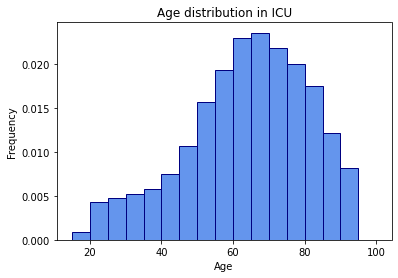

In [13]:
bins = [5*k for k in range(3,21)]
age_plot = plt.hist(L_age, bins=bins, edgecolor='navy', color='cornflowerblue', density=True)
plt.title("Age distribution in ICU")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

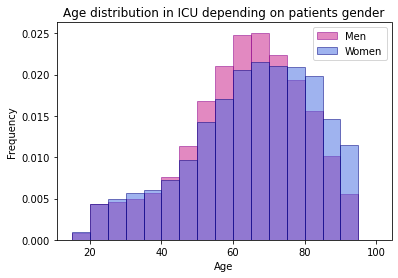

In [12]:
bins = np.linspace(15,100, 18)
plt.hist(M, bins=bins, label="Men", edgecolor='darkmagenta', color='mediumvioletred', alpha=0.5, density=True)
plt.hist(F, bins=bins, label="Women", edgecolor='navy', color='royalblue', alpha=0.5, density=True)
plt.legend()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age distribution in ICU depending on patients gender")
plt.show()

**<u>Race</u>**

Race in not available in the _patients_ table, but in the _admissions_ table.

All patients in ICU do have a race indicated (result of a LEFT JOIN query of _patientICUstays_ table with a table of non-null (`subject_id`, `race`) tuples on `subject_id` where the `race` IS NULL is empty) . However the count of distinct (`subject_id`, `race`) tuple is **66 330**, when there are  only 65 366 distinct patients in ICU. Indeed, **946** patients have several races indicated in their different hospital admissions:
- 1 with 5 races
- 15 with 3 races
- 930 with 2 races

So the collection of distinct (`subject_id`, `race`) is 66 330 but taking into account (by removing) the "extra" races: 66 330 - (5 + 3 × 15 + 2 × 930 - 946) = 65 336 which is indeed the distinct number of patients in the database.

<u>_Example:_</u> _patient_ 10036086 _is indicated 3 times as portuguese and 5 times as white_

To study the race representation among ICU patients, we remove all 946 patients for which the race is inconsistent.

**`df_patient_race` is the csv file of all (`subject_id`, `race`) tuples among ICU patients. `L_patient_severalRace` is the list of all `subject_id` that are registered with different races.**

In [25]:
# all races registered upon admission among ICU patients
df_patient_race = pd.read_csv("../Data/MIMIC-IV/patientsICUrace.csv")
print("The number of races registered is", len(df_patient_race))

# the list of patients (and their subject_id) who have different races indicated
L_patient_severalRace = pd.read_csv("../Data/MIMIC-IV/patientsSeveralRaces.csv")["subject_id"].tolist()
print("The number of patients with several races indicated is", len(L_patient_severalRace))

The number of races registered is 66330
The number of patients with several races indicated is 946


In [26]:
df_patient_race2 = df_patient_race[~ (df_patient_race["subject_id"].isin(L_patient_severalRace))]

# the count/representation of the different races in the database, excluding inconsistent patients
race_count = df_patient_race2["race"].value_counts()
race_count

race
WHITE                                        40100
UNKNOWN                                       7053
BLACK/AFRICAN AMERICAN                        4889
OTHER                                         2133
WHITE - OTHER EUROPEAN                        1589
UNABLE TO OBTAIN                              1587
ASIAN                                          773
ASIAN - CHINESE                                724
HISPANIC/LATINO - PUERTO RICAN                 722
WHITE - RUSSIAN                                549
HISPANIC/LATINO - DOMINICAN                    487
HISPANIC OR LATINO                             478
PATIENT DECLINED TO ANSWER                     413
BLACK/CAPE VERDEAN                             402
BLACK/CARIBBEAN ISLAND                         390
BLACK/AFRICAN                                  269
ASIAN - SOUTH EAST ASIAN                       229
PORTUGUESE                                     223
WHITE - EASTERN EUROPEAN                       183
ASIAN - ASIAN INDIAN      

**<u>Death representation</u>**

- In the entire _admissions_ table, **11 790** rows (identified by `hadm_id`) have a `deathtime` indicated. This represents only **2.16%**
- Among the ICU related admissions only (listed in the _patientICUstays_ table), **9 466** admissions have `deathtime` indicated, which is **11.10%** of the ICU related hospital admissions. Moreover this implies that **80.29%** of the indicated `deathtime` relate to ICU admissions 

In [ ]:
% sql

# number of hospital admissions that have a deathtime indicated
SELECT COUNT(*)
FROM `physionet-data.mimiciv_3_1_hosp.admissions`
WHERE deathtime IS NOT NULL

# number of ICU related hospital admissions that have a deathtime indicated
SELECT COUNT(*)
FROM `physionet-data.mimiciv_3_1_hosp.admissions` A
JOIN `iame-int.ICU.patientICUstays` P
ON A.hadm_id=P.hadm_id
WHERE deathtime IS NOT NULL

- Similarly in the entire _patients_ table, `dod` (date of death) is indicated in **38 301** rows, which represents **58.59%** of the patients.
- Among the ICU patients, death is indicated with `dod` in the _patients_ table for **21 942** (or **33.57%**) of them. So **57.23%** of the indicated date of death relate to ICU patients.

In [ ]:
% sql

# number of dod indicated among all patients
SELECT COUNT(*)
FROM `physionet-data.mimiciv_3_1_hosp.patients`
WHERE dod IS NOT NULL

# number of distinct ICU patients who have a date of death indicated
SELECT COUNT(*)
FROM (SELECT DISTINCT subject_id FROM `iame-int.ICU.patientICUstays`) P
JOIN `physionet-data.mimiciv_3_1_hosp.patients` PP
ON P.subject_id=PP.subject_id
WHERE dod IS NOT NULL

The following query returns a table with all (`subject_id`, `hadm_id`) pairs, the admission time (`admittime`), the `deathtime` indicated in the _admission_ table and the `dod` (date of death) in the _patients_ table. 

In [ ]:
% sql

# death comparison
SELECT P.subject_id, P.hadm_id, A.admittime, PP.dod, A.deathtime, A.discharge_location
FROM `iame-int.ICU.patientICUstays` P
JOIN `physionet-data.mimiciv_3_1_hosp.patients` PP
ON P.subject_id=PP.subject_id
JOIN `physionet-data.mimiciv_3_1_hosp.admissions` A
ON P.subject_id=A.subject_id AND P.hadm_id=A.hadm_id
ORDER BY P.subject_id

# table is result from above query
SELECT *
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonf12176720f5941177b08296d8ba9dc1d89ebb0d35b4189eaa7f201192bd2e139`
WHERE discharge_location = "DIED"
AND deathtime IS NULL AND dod IS NULL

We compare all values to search for inconsistencies. 

- _deathtime_ and _dod_ are always consistent
- where _deathtime_ is indicated, then so is _dod_

However:
- 89 patients died in-hospital but their discharge location is different from "DIED"
- there are also 158 rows where discharge_location=DIED but deathtime is not indicated, and among those rows, 8 have both dod and deathtime null

## Diagnoses representation

We obtain the frequency of the different diagnosis among ICU patients.

In [ ]:
% sql

# diagnoses of ICU patients
CREATE TEMPORARY TABLE patients AS 
    (SELECT P.subject_id, P.hadm_id, DD.long_title
    FROM `iame-int.ICU.patientICUstays` P
    JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` D
    ON P.hadm_id=D.hadm_id AND P.subject_id=D.subject_id
    JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` DD
    ON D.icd_code=DD.icd_code AND D.icd_version=DD.icd_version
    ORDER BY P.subject_id) ;

# first count (see further analysis) of number of diagnosis
SELECT COUNT(DISTINCT long_title) FROM patients ;
    
# frequencies of the different diagnosis
SELECT long_title, 100*COUNT(*)/65366 AS diagnose_freq
FROM patients
GROUP BY long_title

## Data quality: available data, data consistency, table and single-column analysis 

**With a focus on laboratory measurements, drug dosage and pharmacology data**

### **<u>Schema and table relations</u>**
Here we analyse schemas, relations between tables (foreign keys), redundancy of information. We have the following candidate/primary keys, and unique column combinations.

<u>In _hosp_ module:</u>
- _admissions_ : `hadm_id` is a primary key
- _patients_  : `subject_id` is a primary key 
- _diagnoses_icd_ : no primary key, one patient can be diagnosed several diseases upon admission
- _emar_ : `emar_id` is a candidate key, (`subject_id`, `emar_seq`) as well
- _emar_detail_ : (`emar_id`, `parent_field_ordinal`), (`subject_id`, `emar_seq`, `parent_field_ordinal`) are candidate keys (similar to _emar_)
- _prescriptions_ : no primary keys (there are groups of attributes that uniquely identify rows, but that may be null). However no duplicate rows (grouped by a group of attributes and counted)
- _pharmacy_ : `pharmacy_id`
- _microbiologyevents_ : `microevent_id`

<u>In _ICU_ module</u>:
- _icustays_: `stay_id` is a primary key
- _inputevents_ : no candidate/primary keys (_except if we count the distinct values_)

### **<u>Table and single-column analysis</u>**

_For all analysis, unless specified otherwise, we extract the ICU related data. For example, we don't take into account in the list of distinct diagnosis an illness that was not registered for an ICU patient_. There are **85 242** stays in ICU (defined by a `subject_id`-`hadm_id` tuple, where one tuple may be associated with several `stay_id` in case the patient changed unit during his stay). Moreover, a lot of the analysis also imply <mark>JOIN</mark> queries to obtain human-understandable values (for example, the _diagnoses_icd_ table indicates the code for the diagnose, so we perform a join query on the table _d_icd_diagnoses_ to obtain the actual name of the disease.

- null values
- consistency of units, strings, abbreviations etc
- outliers

**In the analysis that follows, we work table by table, checking relations between tables as we work on them**. 

### **<u>ICU stays</u>** - the _icustays_ table (_hosp_ module)

- there is redundancy in the table as all ICU stays have the same first care unit (`first_careunit`) and last care unit (`last_careunit`).

**`df_unitstays` is the csv file of all different intensive care units, the number of stays registered in the database of each of these units and the percentage it represents**.

In [ ]:
% sql

# redundancy of first_careunit and last_careunit features
SELECT COUNT(*)
FROM `physionet-data.mimiciv_3_1_icu.icustays` S
WHERE S.first_careunit=S.last_careunit ;

# different ICU's and the percentage of stays they represent in MIMIC 
SELECT S.first_careunit, COUNT(*) AS count_stays, 100*(COUNT(*)/(SELECT COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.icustays`)) AS percentage_stays
FROM `physionet-data.mimiciv_3_1_icu.icustays` S
GROUP BY S.first_careunit
ORDER BY count_stays DESC ;

In [39]:
df_unitstays = pd.read_csv("../Results/MIMIC-IV/count_unit_stays.csv")
df_unitstays

,first_careunit,count_stays,percentage_stays
0,Medical Intensive Care Unit (MICU),20703,21.917678
1,Medical/Surgical Intensive Care Unit (MICU/SICU),15449,16.355417
2,Cardiac Vascular Intensive Care Unit (CVICU),14771,15.637638
3,Surgical Intensive Care Unit (SICU),13009,13.772259
4,Coronary Care Unit (CCU),10775,11.407186
5,Trauma SICU (TSICU),10474,11.088526
6,Neuro Intermediate,5776,6.114887
7,Neuro Surgical Intensive Care Unit (Neuro SICU),1751,1.853734
8,Neuro Stepdown,1421,1.504372
9,Surgery/Vascular/Intermediate,145,0.153507


In [ ]:
%sql

# distinct ICU patients
SELECT DISTINCT subject_id FROM `physionet-data.mimiciv_3_1_icu.icustays`

### **<u>Diagnoses</u>** - the _diagnoses_icd_ table  (_hosp_ module)

- at first, there are **17 557** different diagnoses among ICU patients

**`df_diagnoses` is the csv file of all illnesses and conditions that were diagnosed for ICU patients, and their frequency among ICU patients**.

In [35]:
df_diagnoses = pd.read_csv("../Data/MIMIC-IV/diagnosesICUpatients.csv")

In [36]:
countCapitalization(df_diagnoses, "long_title")

{'initial_count': 17557,
 'decap_count': 17551,
 'diff_distinct_decap': 6,
 'list_df_diff_cap': ['Pneumonia due to other Gram-negative bacteria',
  'Pneumonia due to other gram-negative bacteria',
  'Budd-Chiari syndrome',
  'Malignant neoplasm of ampulla of vater',
  'Malignant neoplasm of ampulla of Vater',
  'Budd-chiari syndrome',
  'Pneumonia due to staphylococcus, unspecified',
  'Pneumonia due to streptococcus, group B',
  'Pneumonia due to Staphylococcus, unspecified',
  'Pneumonia due to mycoplasma pneumoniae',
  'Pneumonia due to Streptococcus, group B',
  'Pneumonia due to Mycoplasma pneumoniae']}

In [37]:
countExtraSpaces(df_diagnoses, "long_title")

{'initial_count': 17557,
 'nospace_count': 17556,
 'diff_distinct_nosp': 1,
 'list_df_diff_nosp': ['Obstructive sleep apnea (adult) (pediatric)',
  'Obstructive sleep apnea (adult)(pediatric)']}

In [ ]:
diagnose_typos = detectTypos(df_diagnoses, "long_title")
diagnose_typos
THIS CELL WAS NOT RAN (NOR THE FOLLOWING ONE)

As it seems that for diagnose typo detection, the threshold were too high (202 498 potential typos) we extract from the database data with higher thresholds. By filtering, we reduce the detection to 5145 potential typos.

In [ ]:
filtered_diagnose_typos = diagnose_typos[(diagnose_typos["simple_ratio"]==100) 
                                         | (diagnose_typos["token_set_ratio"]==100) 
                                         | (diagnose_typos["token_sort_ratio"]==100)][["s1", "s2"]]

for index, datapoint in filtered_diagnose_typos.iterrows() :
    print(index)
    print("s1 : ", datapoint["s1"])
    print("s2 : ", datapoint["s2"])

In [38]:
typos_indexes = [404,415,424,433,493,744,914,1065,2206,2391,2596,2637,2737,2803,3095,4167,4174,4290,4725,5265,5273,5277,
                5865,5933,5973,6741,6857,7437,7581,8767,8932,9255,9766,9890,9987,10401,12057,12082,12123,12323,13476,
                14240,14351,15216,15498,15675,15806,15874,15876,16430,18273,18510,18572,18592,21236,21246,21276,22649,
                24041,24461,26135,27664,27919,28693,29195,29225,29341,30195,30327,31896,31962,33193,35470,35827,
                36044,36941,41282,41294,41302,41652,42300,44281,45044,46433,46704,46707,48657,49665,49780,50723,50738,
                52187,52905,54213,55044,56322,56914,57494,57495,61038,61625,61831,62164,62172,64022,64932,64972,66678,
                66703,68692,68796,70704,71519,71600,73687,74509,74774,75484,77646,78589,80165,81853,82247,84483,86664,
                90168,91522,91959,97593,97875,98687,101922,102604,104915,107094,110071,111490,114733,119328,119365,
                120577,122540,123315,128385,132515,133845,134745,136738,139201,139314,145219,147033,147233,148514,152072,
                152188,152210,154716,156661,158235,159454,160232,161463,165658,172091,182621,183499,185349,192374,193225,
                195504,197265,201421,202497]

print("Number of typos detected in the distinct diagnoses of patient is", len(typos_indexes))

Number of typos detected in the distinct diagnoses of patient is 174


There are pairs of diagnoses that look like typo but present a subtlety and might be better detected by healthcare professionals, such as _pneumonia due to methicillin susceptible staphylococcus aureus_
and _methicillin susceptible pneumonia due to staphylococcus aureus_ (index $4174$, and $5273$ present the same subtlety).

To understand how the function works: it flaggs for example two similar sentences for which the only difference is "_cerebellar_ artery" versus "_cerebral_ artery" (index $5064$).

Another subtlety that might be better interpreted by healthcare professional is the interchangeably use of the terms "unspecified" and "other" in many sentences (not counted in the 174 mentionned above). For example: "_other place in unspecified non-institutional (private) residence as the place of occurrence of the external cause_" and "_unspecified place in other non-institutional residence as the place of occurrence of the external cause_".

There are also flagged sentences such as (index $18510$) "_unspecified erythematous condition_" and "_erythematous condition, unspecified_", which seems to present a difference in their meaning but it would be up to qualify individuals to confirm or not the equivalence in this case.

### **<u>Microbiology data</u>**: the _microbiologyevents_ table  (_hosp_ module)

1) _The first query returns the list of all the ICU patient stays and the associated microbiology events. If a patient does not have such event, then the tuple (`subject_id`, `hadm_id`) will only appear once with `microevent_id`=NULL (because of left join)_

2) **17 865** ICU patients, or **27.33%** of them, don't have any microbiology data.

3) From this, <u>for patients who do have associated micro data</u>, we can compute the number of `microevent_id` (row in _microbiologyevents_ table) per patient. It ranges from **1** to **514**, with an average of **12.45** microbiology measurements (rows in _microbiologyevents_ table) per patient admission ((`subject_id`, `hadm_id`) pair).

4) For patients who <u>do have microbiology data associated</u>, we compute the number of micro-tests performed for each specimen (from MIMIC documentation: _specimen from which the microbiology measurement was made. Most microbiology measurements are made on patient derived samples (specimens) such as blood, urine, and so on. Often multiple measurements are made on the same sample, and the `micro_specimen_id` will group measurements made on the same sample, e.g. organisms which grew from the same blood sample_). From this we obtain that the average number of tests per patient's specimen is **1.99**, ranging between **1** and **54**.

In [ ]:
% sql

# query 1)
SELECT I.subject_id, I.hadm_id, M.microevent_id 
FROM `iame-int.ICU.patientICUstays` I 
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id ;

# query 2)
# from query 1) 
# note that here we write a nested query but in reality, we query from the above result table
SELECT COUNT(*) 
FROM (
    SELECT I.subject_id, I.hadm_id, M.microevent_id 
    FROM `iame-int.ICU.patientICUstays` I 
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
    ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id ;)
WHERE microevent_id IS NULL 

# query 3)
# here again, nested query but we actually simply query result from query 1
SELECT subject_id, hadm_id, COUNT(*) AS count_micro
FROM (
    SELECT I.subject_id, I.hadm_id, M.microevent_id 
    FROM `iame-int.ICU.patientICUstays` I 
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
    ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id ;)
WHERE microevent_id IS NULL 
GROUP BY subject_id, hadm_id
ORDER BY count_micro DESC

# query 4)
CREATE TEMPORARY TABLE microeventsICU AS (
  SELECT I.subject_id, I.hadm_id, M.microevent_id, M.micro_specimen_id
  FROM `iame-int.ICU.patientICUstays` I 
    JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
  ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id 
) ;
SELECT subject_id, hadm_id, micro_specimen_id, COUNT(*) AS test_count
FROM microeventsICU 
GROUP BY subject_id, hadm_id, micro_specimen_id ;

**For the rest of the microbiology analysis for ICU patients, we extract the ICU related data and save the result as a new BigQuery table named _microbiologyeventsICU_.**

_The constraint on having a unique microevent_id identifier for each row is respected (see <mark>validation query</mark>_.

Among all the **856 452** (ICU related) microbiology events, **313 195** are associated with the detection of an organism.

In [ ]:
% sql

# validation query for microevent_id being a unique identifier
SELECT microevent_id, COUNT(*) AS count_microID
FROM  `iame-int.ICU.microbiologyeventsICU`
GROUP BY microevent_id
HAVING count_microID > 1

# number of rows that detect an organism
SELECT * FROM `iame-int.ICU.microbiologyeventsICU` 
WHERE org_itemid IS NOT NULL

**<u>Overview</u>** of the _microbiologyeventsICU_ table

- **856 452** rows
- **6** possible interpretations
- **595 924** null interpretations
- **4** possible values for quantities + NULL
- **856 409** null quantities → most of _quantity_ fields are empty (only **43** or less than **0.01%** rows have the value)

The `quantity` field has 5 possible values:
	
- null	
- MODERATE	
- SPARSE GROWTH	
- 10,000-100,000 CFU/mL	
- strictly bigger than 100,000 CFU/mL

In [ ]:
% sql

# distinct values for quantity feature
SELECT DISTINCT quantity FROM `iame-int.ICU.microbiologyeventsICU`

# different counts for number of ICU microbiology events, interpretation, 
# null interpretation, quantity, null quantity
SELECT COUNT(*), COUNT(DISTINCT interpretation) AS unique_interpretation, 
  (SELECT COUNT(*)  FROM `iame-int.ICU.microbiologyeventsICU` WHERE interpretation IS NULL) AS null_interpretation,
  COUNT(DISTINCT quantity) AS unique_quantity,
  (SELECT COUNT(*) FROM `iame-int.ICU.microbiologyeventsICU` WHERE quantity IS NULL) AS null_quantity
FROM  `iame-int.ICU.microbiologyeventsICU`

**<u>Null values</u>** in _microbiologyeventsICU_

**In the _microbiologyeventsICU table_, there is an important number (**17865) of fully empty rows** (_there is an `microevent_id` but not any other data_). This represents **2.09%** of the table.


**200 785** rows (microbiology events) don't have any comments. Moreover looking closely at the comments, some of them can be considered to indicate the row as "null" for a study that would require the test to detect an organism:
- ___ (**67783** such rows; they indicate that the content has been fully de-identified)
- NO GROWTH.
- No significant growth.
- No growth to date.

Other comments specifically indicate the absence of growth observed, such as:
- NO MYCOBACTERIA ISOLATED.  
- NO LEGIONELLA ISOLATED.

Finally, several tests have indications that they were cancelled, but are still recorded in the microbiologyevents table. They will thus not provide any information to reasearch on such tests, unless related with administration or cancellation of such events. Comments provide information such as:
- TEST CANCELLED, PATIENT CREDITED.
- TEST NOT PERFORMED. 

### **TO DO**
identify how many rows are actually affected by those cases

In [ ]:
% sql

# 1) 
SELECT COUNT(*) FROM `iame-int.ICU.microbiologyeventsICU` WHERE comments IS NULL

**<u>Redundancy of columns</u>** in _microbiologyeventsICU_

- `dilution_text`, `dilution_value`, `dilution_comparison`: `dilution_text` is a concatenation of the two others OR `dilution_text` is only the formatted version of `dilution_value`, so there are three columns but only one gives the necessary information (to some extent, 2 if it is required to have the value as a float and the comparison as a string. But such processing can be done by the researcher). 

As the number of rows in _microbiologyeventsICU_ is huge, we are not able to export all the data from Google BigQuery. We check the aforementioned issue on a sample of **30 794** rows among the **250 439** rows that do have dilution variables, and find that it is valid for 100% of the sample.

**`df_sample_dilu` is the csv file containing the sample of 30 794 rows corresponding to microbiology events that do have dilution variables**.

In [40]:
df_sample_dilu = pd.read_csv('../Data/MIMIC-IV/microICU_nonemptydilution.csv')
print(df.columns)

Index(['microevent_id', 'subject_id', 'hadm_id', 'micro_specimen_id',
       'order_provider_id', 'chartdate', 'charttime', 'spec_itemid',
       'spec_type_desc', 'test_seq', 'storedate', 'storetime', 'test_itemid',
       'test_name', 'org_itemid', 'org_name', 'isolate_num', 'quantity',
       'ab_itemid', 'ab_name', 'dilution_text', 'dilution_comparison',
       'dilution_value', 'interpretation', 'comments'],
      dtype='object')


In [41]:
n_e = 0
index = 0
dilution_data = df[['dilution_text', 'dilution_comparison', 'dilution_value']]


for index, datapoint in dilution_data.iterrows() :
    index += 1
        
    dilution_text = datapoint['dilution_text']
    dilution_comparison = datapoint['dilution_comparison']
    dilution_value = datapoint['dilution_value']
    
    dilution_value_str = "{:g}".format(dilution_value)

    if dilution_text == dilution_comparison.strip() + dilution_value_str or dilution_text == dilution_value_str:
        n_e += 1
        
print("The percentage of this sample that satisfied the explained characteristic is " + str(100* n_e/len(dilution_data)) + "%" )

The percentage of this sample that satisfied the explained characteristic is 100.0%


**<u>Medical sense and value consistency</u>** in _microbiologyeventsICU_ table

For `interpretation` field, the MIMIC guide indicates that the letters 'S', 'R', 'I', 'P' stand for sensitive, resistant, intermediate, pending. This corresponds to the typical MIC qualitative categories for interpretation of results. However, **123** rows have the letters 'D', 'Z', 'N'

In [ ]:
% sql

SELECT * FROM `iame-int.ICU.microbiologyeventsICU` 
WHERE interpretation != "R"
AND interpretation != "I"
AND interpretation != "S"
AND interpretation != "P"

**`intepretation`** is very often left empty (even when selecting the tests that are actually performed): **595,924** out of the **856,452** rows.

In [ ]:
%sql
SELECT * FROM `iame-int.ICU.microbiologyeventsICU` where interpretation IS NULL

**`test_name`**

All abbreviation used for the test names are correct. There are no capitalizations nor spaces inconsistencies, and we don't detect any typos.

**`df_testnames` is the csv file of all distinct `test_name` in _microbiologyeventsICU_**.

In [43]:
df_testnames = pd.read_csv('../Data/MIMIC-IV/micro_distinct_testname.csv')
print("The number of values for test_name in the micro table is " + str(len(df_testnames)))

The number of values for test_name in the micro table is 142


In [46]:
detectTypos(df_testnames, "test_name")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,hbv viral load,hcv viral load,93,93,93,0.150756
1,epstein-barr virus vca-igg ab,epstein-barr virus vca-igm ab,97,97,97,0.088391
2,cmv igm antibody,cmv igg antibody,94,94,94,0.150756
3,direct influenza a antigen test,direct influenza b antigen test,97,94,97,0.074958
4,hcv viral load,cmv viral load,93,93,93,0.150756
5,r/o beta strep group a,r/o group b beta strep,64,95,95,0.100000
6,toxoplasma igg antibody,toxoplasma igm antibody,96,96,96,0.107833
7,molecular cytogenetics-dna probe,molecular cytogenetics - dna probe,97,100,100,0.116343
8,aerobic bottle gram stain,anaerobic bottle gram stain,96,96,96,0.092934


**`culture_site`** has only one inconsistency, in letter capitalization ("SWAB" and "Swab")

**`df_culture_site` is the csv file of all distinct culture sites**.

In [69]:
df_culture_site = pd.read_csv("../Data/MIMIC-IV/microbiologyICU_culturesite.csv")
print(df_culture_site)

               spec_type_desc       f0_
0                        SWAB  0.817055
1                       STOOL  0.910205
2                 Blood (EBV)  0.074494
3                  IMMUNOLOGY  0.048844
4      BRONCHOALVEOLAR LAVAGE  0.945960
..                        ...       ...
77                FLUID WOUND  0.001429
78            CATHETER TIP-IV  0.200265
79               FOOT CULTURE  0.005566
80  URINE,SUPRAPUBIC ASPIRATE  0.000853
81    URINE,PROSTATIC MASSAGE  0.000025

[82 rows x 2 columns]


In [50]:
countCapitalization(df_culture_site, "spec_type_desc")
countExtraSpaces(df_culture_site, "spec_type_desc")
detectTypos(df_culture_site, "spec_type_desc")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance


### **<u>Lab events:</u>** the _labevents_ table  (_hosp_ module)

1) We first create a <mark>temporary table</mark> to obtain, for all patients in ICU, their `subject_id`, `hadm_id`, the `specimen_id`, the `label` for the laboratory concept, the `fluid` (the substance on which the measurement is made), and the `category` (type of measurement) of the test. In total, the data contains measurements for **4 282 501** differement fluid samples. 

2) With a similar query and a <mark>left join</mark> we compute that the number of ICU patients with no laboratory data is **773** or only **1.18%** of the ICU patients.

In [ ]:
% sql

# query 1)
CREATE TEMPORARY TABLE labeventsICU AS (
  SELECT I.subject_id, I.hadm_id, L.specimen_id, D.label, D.fluid, D.category
  FROM `iame-int.ICU.patientICUstays` I 
  JOIN `physionet-data.mimiciv_3_1_hosp.labevents` L
  ON I.subject_id=L.subject_id AND I.hadm_id=L.hadm_id 
  JOIN `physionet-data.mimiciv_3_1_hosp.d_labitems` D ON D.itemid=L.itemid
  ORDER BY subject_id
) ;

### **<u>Electronic Medicine Administration Record (eMAR)</u>**

**As indicated in the MIMIC guidelines, the eMAR system was only implemented over 2011-2013, thus the data is not available for all patients.**

- _emar_ : to record administration of a given medicine to an individual patient
- _emar_detail_ : information for each medicine administration made in the EMAR table
- _pharmacy_ : provides detailed information regarding filled medications which were prescribed to the patient
- _prescriptions_ : provides information about prescribed medications

_Now we extract from the four above tables the data associated with the ICU stays (`subject_id`-`hadm_id` tuples)_.

- 1) emar data from ICU patients. _the result set will include all rows from the tables that satisfy the join condition. If there are multiple rows in table E (physionet-data.mimiciv_3_1_hosp.emar) that have the same (`subject_id`, `hadm_id`) combination and this combination matches a row in table P (iame-int.ICU.patientICUstays), all those rows from table E will appear in the result set._ This is an extremely big table (**17 180 721** rows) and for the purpose of computations, we first extract 50,000 rows only. **As it is a huge table, for the purpose of checking we extract a sample of 50 000 rows of emar ICU data, that we save as a BigQuery table named _emarICUsubset_**.

Based on this subset, we extract the corresponding rows from the other tables. _Note that this does not include the foreign keys leading "nowhere" since we are performing a join_. **Moreover, because we perform the join on _emarICUsubset_, the following queries also return only a subset of the ICU related data**.

2) subset of emar_detail (**96,594** rows): _emar_detailICUsubset_

3) subset of pharmacy (**37 941**rows): _pharmacyICUsubset_

4) subset of prescriptions (**44 288** rows): _prescriptionsICUsubset_

## **TO DO** 
Finish checking the foreign keys 

In [ ]:
%sql

# query 1) 
SELECT E.* 
FROM `physionet-data.mimiciv_3_1_hosp.emar` E
JOIN `iame-int.ICU.patientICUstays` P
ON P.subject_id=E.subject_id AND P.hadm_id=E.hadm_id

# query 2)
SELECT ED.* FROM `iame-int.ICU.emarICUsubset` E
JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
ON E.emar_id=ED.emar_id

# query 3)
SELECT P.* FROM `iame-int.ICU.emarICUsubset` E
JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
ON E.pharmacy_id=P.pharmacy_id

# query 4) 
SELECT P.* FROM `iame-int.ICU.emarICUsubset` E
JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` P
ON E.pharmacy_id=P.pharmacy_id

**<u>Overview</u>** (on relation between the four tables)


1) ICU patients stays that don't have any associated emar data: there are **34 696** rows in the result table (_identified with right join_) so quite a lot: **53.1%** of ICU patients don't have emar data.

2) <u>Based on sample data</u>, all the rows in _emar_ are associated with an `emar_id`, and all `emar_id` in _emar_ are valid (they actually lead to a row in _emar_detail_) 

3) Similarly all rows in _emar_detail_ lead to a row in _emar_ based on `emar_id`

In [ ]:
%sql

# 1) query to identify ICU patient admissions that don't have any eMAR data
SELECT P.subject_id, P.hadm_id, E.emar_id
FROM `physionet-data.mimiciv_3_1_hosp.emar` E
RIGHT JOIN `iame-int.ICU.patientICUstays` P
ON E.subject_id=P.subject_id
AND E.hadm_id=P.hadm_id 
WHERE E.emar_id IS NULL 

# 2) emar_id in emar
SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset`
WHERE emar_id IS NULL

# validation queries for link emar → emar_detail on emar_id
SELECT * FROM `iame-int.ICU.emarICUsubset` E
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
ON E.emar_id=ED.emar_id
AND E.subject_id=ED.subject_id

# result from above query
SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon7ec88dc37309ae5050bb48dfa9de80e6598cf80c3a72bc6fee7164a118500414`
WHERE emar_id_1 IS NULL

# 3) validation queries for link emar_detail → emar on emar_id
SELECT E.emar_id, ED.emar_id FROM `physionet-data.mimiciv_3_1_hosp.emar` E
RIGHT JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
ON E.emar_id=ED.emar_id

# resutl from above query
SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anonb0e8f58c9cfca1026baea4086c3cd9f541baf48a4ac927439462c7c24665d32b`
WHERE emar_id IS NULL

1) In _emarICUsubset_, **12042** rows in emar don't have any associated pharmacy

2) In _emarICUsubset_ (**among the subset of ICU patients only**), there are **17** pharmacy references (pharmacy_id) that lead nowhere. The list of such pharmacies is listed in a saved file (_emar_wrongpharmacyid_). The last query checks this fact based on the saved list.

3) Following the discovery in 2), we check on the whole data set (including non ICU emar information). There are **727 392** pharmacy references in _emar_ that don't have a matching pharmacy in the table _pharmacy_. (the left join of emar on pharmacy gave **34 493 895** rows). We check with an inner join (last query in 3) ) and we indeed get "no data to display"

4) we check the same for _emar_detail_ table and we find **910 580** non-matching rows. **NOTE that this is a number of rows and not a number of distinct pharmacy ids**

5) note that there are **17 847 567** distinct pharmacy ids in _pharmacy_ table

There are **210 897** distinct `pharmacy_id` in _emar_, and **212 610** in _emar_detail_. Among this, they have **210 893** erroneous `pharmacy_id` in common and there is a total of **212 614** wrong `pharmacy_id`. _The list of these wrong `pharmacy_id` can be obtained from above queries_.

In [ ]:
#1) emar rows that don't have a pharmacy_id
SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset`
WHERE pharmacy_id IS NULL

# 2) rows in emarICUsubset with a pharmacy_id and the corresponding data from pharmacy
SELECT * FROM `iame-int.ICU.emarICUsubset` E
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
ON E.pharmacy_id=P.pharmacy_id
WHERE E.pharmacy_id IS NOT NULL

# from result of previous query, number of pharmacy referenced in emarICUsubuset but not in pharmacy
SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon06ee8a38eca098809f7d754f3df6d6c3e359cc4d7a6a50d94b9e4d274fa45379`
WHERE pharmacy_id_1 IS NULL

SELECT * FROM `physionet-data.mimiciv_3_1_hosp.pharmacy` P
JOIN `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon3e47e990bee7b688cca0695e14422371ca7e260183ffd10f4210ca282e322a89` WP
ON WP.pharmacy_id=P.pharmacy_id

# 3) join of emar pharmacy_id (when non-null) with pharmacy table
SELECT E.pharmacy_id, P.pharmacy_id
FROM `physionet-data.mimiciv_3_1_hosp.emar` E 
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
ON E.pharmacy_id=P.pharmacy_id
WHERE E.pharmacy_id IS NOT NULL

# with result from above query, count of pharmacy_id referenced in emar but non-existant in pharmacy
SELECT *
FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon84dad9c68bb441ad079fc1752509f112400e420f5e42533b2eba044751d9428c`
WHERE pharmacy_id_1 IS NULL 

# with result from above query, validation query that those pharmacies indeed don't exist in pharmacy table
# result from query is empty
SELECT * FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon2018b5710b8ed11cec509fcaf6674d17854125cd27003f9b88be29b31a35442d` WP
JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
ON WP.pharmacy_id = P.pharmacy_id

# 4) join of emar_detail to pharmacy on pharmacy_id (when non-null)
SELECT E.pharmacy_id, P.pharmacy_id
FROM `physionet-data.mimiciv_3_1_hosp.emar_detail` E 
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
ON E.pharmacy_id=P.pharmacy_id
WHERE E.pharmacy_id IS NOT NULL

# with result from above query, count of non-existing pharmacies
SELECT COUNT(*)
FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon73b1cb194b0e0fb85e3f52e3513d7f2d80ecc038a1a3b85f6b147f23698c958a`
WHERE pharmacy_id_1 IS NULL 

# 5) number of distinct pharmacy id's in pharmacy table
SELECT COUNT(DISTINCT pharmacy_id) FROM `physionet-data.mimiciv_3_1_hosp.pharmacy`

Note that the _emar_ table is also linked to the _prescription_ table through `pharmacy_id`.

1) **897 907** rows (not distinct) in _emar_detail_ have a `pharmacy_id` but are not linked to a row in _prescriptions_ (but the `pharmacy_id` could also point to a row in the pharmacy table!)

2) among the **distinct** pharmacies that are not associated with prescriptions info, we find that **241 318** of those `pharmacy_id` that are don't have associated data in the _prescriptions_ table, don't either **210 897** in the _pharmacy_ table.

In [ ]:
%sql

# 1) join of emar and pharmacy on pharmacy_id
SELECT E.pharmacy_id, P.pharmacy_id
FROM `physionet-data.mimiciv_3_1_hosp.emar` E
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` P
ON E.pharmacy_id = P.pharmacy_id
AND E.subject_id = P.subject_id
AND E.hadm_id = P.hadm_id 
WHERE E.pharmacy_id IS NOT NULL

# with result from above query, count of the number of rows in emar that don't have data in prescriptions
SELECT COUNT(*)
FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon54687415cdbb70e4e0823f1f6892e4186fb483e869f98425189fc2216d330119`
WHERE pharmacy_id_1 IS NULL 

# 2) selection of all the pharmacies that are not associated with prescriptions data
SELECT *
FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon54687415cdbb70e4e0823f1f6892e4186fb483e869f98425189fc2216d330119`
WHERE pharmacy_id_1 IS NULL # pharmacies not associated with prescription info

# with result from above queries (pharmacy_id in emar with no prescriptions data)
# this is the number of distinct pharmacies that don't have an associated prescription
# (computations could have been done in a more simple way)
SELECT COUNT(*)
FROM (SELECT DISTINCT pharmacy_id FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anonee762dc034d61f059fcfadf24f9fd526006fabd2a2597da5435d987b4a237a4a`) A
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` P
ON A.pharmacy_id = P.pharmacy_id
WHERE P.pharmacy_id IS NULL

# same query as above except that join on pharmacy
SELECT COUNT(*)
FROM (SELECT DISTINCT pharmacy_id FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anonee762dc034d61f059fcfadf24f9fd526006fabd2a2597da5435d987b4a237a4a`) A
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
ON A.pharmacy_id = P.pharmacy_id
WHERE P.pharmacy_id IS NULL

### **<u>Emar:</u>** the _emar_ table  (_hosp_ module)

**Null values** 

- (in the entire _emar_ table) all values do have an `emar_id` identifier and each `emar_id` is indeed unique to one row. Morevoer, each (`emar_id`, `emar_seq`) tuple is also unique (although `emar_seq` is not). As it should be, the tuple (`subject_id`, `emar_seq`) also uniquely identifies a row. **`emar_id` is actually a combination of `subject_id` and `emar_seq` so there is redundancy in the information**
- the average number of rows in _emar_ per subject and stay: **105.57**. The average number of rows in _emarICUsubset_ per subject and (ICU) stay: **2.31**
- now filtering on the data where the `medication` is indicated and was "Administered", we find that the average number of rows in _emar_ per subject and stay is **71.60** and the average number of rows in _emarICUsubset_ per subject and (ICU) stay is **1.99**

_**well there is obviously smth weird going on here**_

In [ ]:
% sql

# rows that have null emar_id
# no data to display from this query
SELECT * FROM `physionet-data.mimiciv_3_1_hosp.emar` WHERE emar_id IS NULL 

# emar_id that are in more than one row
# no data to display from this query
SELECT emar_id, COUNT(*) FROM `physionet-data.mimiciv_3_1_hosp.emar`
GROUP BY emar_id
HAVING COUNT(*) > 1

# emar_seq-subject_id that are in more than one row
# no data to display from this query
SELECT subject_id, emar_seq, COUNT(*) FROM `physionet-data.mimiciv_3_1_hosp.emar`
GROUP BY subject_id, emar_seq
HAVING COUNT(*) > 1 

# average number of emar rows per patient admission 
# in the entire emar table
SELECT AVG(emar_subjectStay_count)
FROM (
  SELECT COUNT(*) AS emar_subjectStay_count
  FROM `physionet-data.mimiciv_3_1_hosp.emar`
  GROUP BY subject_id, hadm_id
)

# average number of emar rows per patient admission 
# in the emarICUsubset table
SELECT AVG(emar_subjectStay_count)
FROM (
  SELECT COUNT(*) AS emar_subjectStay_count
  FROM `iame-int.ICU.emarICUsubset`
  GROUP BY subject_id, hadm_id
)

# average number of emar rows for each patient admission
# for medication that was actually administered
# in the entire emar table
SELECT AVG(emar_subjectStay_count)
FROM (
  SELECT COUNT(*) AS emar_subjectStay_count
  FROM `physionet-data.mimiciv_3_1_hosp.emar`
  WHERE medication IS NOT NULL
  AND event_txt="Administered"
  GROUP BY subject_id, hadm_id
) ;

# average number of emar rows for each patient admission
# for medication that was actually administered
# in the emarICUsubset table
SELECT AVG(emar_subjectStay_count)
FROM (
  SELECT COUNT(*) AS emar_subjectStay_count
  FROM `iame-int.ICU.emarICUsubset`
  WHERE medication IS NOT NULL
  AND event_txt="Administered"
  GROUP BY subject_id, hadm_id
)

In the _emar_ table, the name of the medication which was administered is indicated in the column `medication`. We take a look at the names and abbreviations used. 

**In the following, we perform our analysis on the subset _emarICUsubset_**.

First of all observe that **927** rows have an empty medication field.

**65.47%** of the medication was administered 

In [ ]:
%sql

# the distinct medications administered
SELECT DISTINCT medications FROM `iame-int.ICU.emarICUsubset` ORDER BY medication

# number of rows that have null medication
SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset` WHERE medication IS NULL

# percentage of administered medication 
SELECT 100 * COUNT(*) / (SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset`)
FROM `iame-int.ICU.emarICUsubset` 
WHERE event_txt="Administered"

**`df_medication` is the csv file of all distinct medication administered in the _emarICUsubset_ table**.

- In the _emarICUsubset_, **there are 36 medication labels that are written with different capitalized letters**. This issue should be known and taken into account when applying ML algorithms with classification (and the detection of these errors should be performed on the entire ICU related emar data)
- There are 2 medication labels that appear with different number of spaces
- 4 typos in the medication labels

In [78]:
df_medication = pd.read_csv('../Data/MIMIC-IV/emar_medicationICUdistinct.csv')
print("The number of distinct medication labels in the table related to medication administered in ICU is " + str(len(df_medication))) 
df_medication.head()

The number of medication labels in the table related to medication administered in ICU is 852


,medication
0,23.4% Sodium Chloride
1,AMOXicillin Oral Susp.
2,APAP/Placebo
3,ARIPiprazole
4,AcetaZOLamide


In [79]:
countCapitalization(df_medication, "medication")

{'initial_count': 852,
 'decap_count': 816,
 'diff_distinct_decap': 36,
 'list_df_diff_cap': ['Amlodipine',
  'Ascorbic Acid/Thiamine/Placebo',
  'Ascorbic acid/thiamine/placebo',
  'CYCLOSPORINE 0.05% OPHTH EMULSION',
  'CarBAMazepine',
  'CarBAMazepine (Extended-Release)',
  'CarBAMazepine Suspension',
  'Carbamazepine',
  'Carbamazepine (Extended-Release)',
  'Carbamazepine Suspension',
  'CeFAZolin',
  'CefTRIAXone',
  'CefazoLIN',
  'Ceftolozane-Tazobactam',
  'CeftriaXONE',
  'CloNIDine',
  'CloniDINE',
  'CoQ10 (300mg) or Placebo',
  'CoQ10 (300mg) or placebo',
  'Cyclosporine 0.05% Ophth Emulsion',
  'FLUoxetine',
  'Fluoxetine',
  'GuaiFENesin',
  'GuaiFENesin ER',
  'GuaiFENesin-CODEINE Phosphate',
  'GuaiFENesin-Dextromethorphan',
  'Guaifenesin',
  'Guaifenesin ER',
  'Guaifenesin-CODEINE Phosphate',
  'Guaifenesin-Dextromethorphan',
  'HYDROcodone-Acetaminophen (5mg-325mg)',
  'Hydrocodone-Acetaminophen (5mg-325mg)',
  'Hydrocortisone Study Drug',
  'Hydrocortisone study d

In [80]:
countExtraSpaces(df_medication, "medication")

{'initial_count': 852,
 'nospace_count': 850,
 'diff_distinct_nosp': 2,
 'list_df_diff_nosp': ['Potassium Chloride Replacement (Critical Care and Oncology)',
  'Potassium Chloride Replacement (Critical Care and Oncology) ',
  'nimodipine 60mg/ placebo',
  'nimodipine 60mg/placebo']}

In [81]:
d_med = detectTypos(df_medication, "medication")

In [83]:
for index, datapoint in d_med.iterrows() :
    print(1, datapoint["s1"])
    print(2, datapoint["s2"])

1 thiamine or placebo
2 thiamine of placebo
1 risperidone oral solution
2 prednisolone oral solution
1 hydrocodone-acetaminophen (5mg-325mg)
2 hydrocodone-acetaminophen (5mg-500mg)
1 hydrocodone-acetaminophen (5mg-325mg)
2 oxycodone--acetaminophen (5mg-325mg)
1 hydrocodone-acetaminophen (5mg-325mg)
2 oxycodone-acetaminophen (5mg-325mg)
1 amphetamine-dextroamphetamine
2 amphetamine-dextroamphetamine xr
1 ampicillin desensitization
2 nafcillin desensitization
1 betamethasone dipro 0.05% lot.
2 betamethasone dipro 0.05% oint
1 brimonidine tartrate 0.15% ophth.
2 brimonidine tartrate 0.2% ophth.
1 buprenorphine-naloxone (2mg-0.5mg)
2 buprenorphine-naloxone (8mg-2mg)
1 buprenorphine-naloxone film (2mg-0.5mg)
2 buprenorphine-naloxone film (4mg-1mg)
1 buprenorphine-naloxone film (2mg-0.5mg)
2 buprenorphine-naloxone film (8mg-2mg)
1 buprenorphine-naloxone film (4mg-1mg)
2 buprenorphine-naloxone film (8mg-2mg)
1 buprenorphine-naloxone tablet (2mg-0.5mg)
2 buprenorphine-naloxone tablet (8mg-2mg)


Among the `medication` that is not indicated, we are curious as how come this information is missing (since the eMAR is associated with the QRcode of the medication scanned before administration).

1) We extract the `event_txt` labels associated with missing medication name. We find 20 reasons, most of them corresponding to the medication not being actually administered:

- Not confirmed
- Delayed Started
- Delayed Confirmed
- in Other Location
- Stopped As Directed
- Stopped - Unscheduled
- Infusion Reconciliation
- Started in Other Location (9 rows out of 51 rows)
- Stopped in Other Location
- Confirmed in Other Location (5 rows out of 12 rows)
- Not Given per Sliding Scale
- Administered in Other Location (8 rows out of 199 rows)
- Administered Bolus from IV Drip
- Delayed Stopped
- Delayed Not Started
- Delayed Administered
- Partial Administered (1 row out of 40)
- TPN Rate Not Changed (1 row)
- Not Started per Sliding Scale
- Stopped - Unscheduled in Other Location

However this still implies a few missing data, for example even if the data is only partially administered the medication should be indicated. (_in parenthesis is given the number of rows in the database_ emarICUsubset _that have the indicated `event_txt`, and the number of rows among them that have NULL `medication`_). 

In [ ]:
%sql

# 1) distinct event_txt associated with emar data where medication was not administered
SELECT DISTINCT event_txt FROM `iame-int.ICU.emar_emptyMedicationICU_subset`

### **<u>Emar detail:</u>** the _emar_detail_ table  (_hosp_ module)

_emar_detailICUsubset_ has **96 594** rows.

`emar_id`

- In average in the _emar_detailICUsubset_ (obtained from the joining the _emarICusubset_ on _emar_detail_, see before), `emar_id` (rows in _emar_) have **1.93** associated rows in _emar_detail_, ranging from **1** to **17**
- **11 422** `emar_id` have only one associated row in _emar_detailICUsubset_, which represents (11422/50000) **22.84%** (_to compute the percentage, the denominator is 50000 because that is the number of `emar_id`'s = the number of rows in emarICUsubset_)
- **64.67%** of `emar_id` have 2 associated rows in _emar_detailICUsubset_ (**32336** `emar_id`'s), **22.84%** have **1**, and **10.14%** have **3** (**5071** `emar_id`'s).

In [ ]:
% sql

# statistics on the number of rows in emar detail for each emar_id
SELECT MIN(emar_count), MAX(emar_count), AVG(emar_count)
FROM (
  SELECT emar_id, COUNT(*) AS emar_count
  FROM `iame-int.ICU.emar_detailICUsubset`
  GROUP BY emar_id
)

# number of emar_id from emarICUsubset that only have one associated row in emar_detail
SELECT emar_id, COUNT(*) AS emar_count
FROM `iame-int.ICU.emar_detailICUsubset`
GROUP BY emar_id
HAVING emar_count = 1

# the three main number of rows in emar_detailICUsubset for an emar_id
SELECT emar_count, COUNT(*) AS emar_count_count # the number of times a value for emar_count appears
FROM (
  SELECT COUNT(*) AS emar_count # the number of rows in emar detail per emar_id
  FROM `iame-int.ICU.emar_detailICUsubset`
  GROUP BY emar_id
)
GROUP BY emar_count
ORDER BY emar_count_count DESC
LIMIT(3) 

- Among the 96 594 rows of _emar_detailICUsubset_, **46 596** have empty `administration_type`
- There are **19** distinct values of `administration_type` (including null). We visually check that all administration types are unique (no problem with capitalization


- **!** in a lot of cases, when the `administration_type` is null, the `parent_field_ordinal` is not (only 3 rows have both field null, otherwise for all the rest, null `administration_type` implies non-null `parent_field_ordinal`. Moreover the 3 rows that have both fields null are also for the rest mainly empty)


- In the _emar_detailICU_ table, **50 000** rows have an empty `parent_original_field`. This is consistent with the number of `emar_id`'s in _emarICUsubset_ (each `emar_id` must have at least one row with that field empty as it is the first administration. This is consistent with the fact that **49 997** only among the rows that have  `parent_original_field` empty also have `administration_type` empty. **interpretation:** we can make a generalization that if an `emar_id` has several associated emar_detail information, the first associated line will have `parent_original_field` null and will indicate the administration type. The other associated rows, with non-null `parent_original_field`, should have the same administration type as the first row. There are only **3** rows not following this rule, the 3 ones mentionned above.

**`df_administration_type` is the list of distinct values for `administration_type` and their count in the _emar_detailICUsubset_ table**

In [85]:
df_administration_type = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_distinct_administration_types.csv')
df_administration_type

,administration_type,count_admin_type
0,NaN,46597
1,Argatroban IV Infusion,10
2,Bolus Dose from IV Drip,1076
3,Epidural,16
4,Heparin IV Infusion,331
5,IV Fluid Repletion,1
6,IV Flush,140
7,IV Infusion,3986
8,Insulin Infusion (IV Drip),153
9,Insulin SC Fixed Dose,18


In [ ]:
% sql

# number of times each administration type was registered in emar_detailICUsubset
SELECT administration_type, COUNT(*) AS count_admin_type
FROM `iame-int.ICU.emar_detailICUsubset` 
GROUP BY administration_type
ORDER BY administration_type ;

# count of null administration types
SELECT COUNT(*)
FROM `iame-int.ICU.emar_detailICUsubset` 
WHERE administration_type IS NULL

# in emar_detailICUsubset, rows where both administration_type and parent_field_ordinal are null
# result is 3
SELECT COUNT(*)
FROM `iame-int.ICU.emar_detailICUsubset` 
WHERE administration_type IS NULL 
AND parent_field_ordinal IS NULL 

# the 3 rows that have both fields null
SELECT *
FROM `iame-int.ICU.emar_detailICUsubset` 
WHERE administration_type IS NULL 
AND parent_field_ordinal IS NULL

# number of rows in emar_detailICUsubset where the parent_ordinal_field is null
SELECT COUNT(*) FROM `iame-int.ICU.emar_detailICUsubset` WHERE parent_field_ordinal IS NULL

# rows where administration_type is not null but parent_field_ordinal is
SELECT *
FROM `iame-int.ICU.emar_detailICUsubset` 
WHERE administration_type IS NOT NULL 
AND parent_field_ordinal IS NULL

In general, we note that the _emar_detailICUsubset_ has a lot of null fields. 
_This might be due to the fact that there are a lot of fields in the table (**33**) giving more precise information about the medication administration. However among those field, some don't apply to all types of medication (for example, transdermal patch don't have an infusion_rate_. see example).

so in **<u>emar_detailICUsubset</u>**:

- `subject_id`
- `emar_id`
- `emar_seq`
- `parent_field_ordinal`
- `administration_type`


- `pharmacy_id` (_we have computed above the number of erroneous `pharmacy_id` fields. **50 689** rows have an empty `pharmacy_id` field, and most of them (**50 145**) correspond to an empty `barcode_type`)_. **There are 143 joined rows where the row in _emarICU_ and a corresponding row in _emar_detailICU_ don't have the same `pharmacy_id`. It is always linked to the same medication in the _pharmacy_ table. **!!** They always corespond to `parent_original_field` being non-empty, thus a second administration of the medicament. 
- By curiosity, we look at `emar_id` having different `pharmacy_id`'s. Overall, **31 776** `emar_id`'s have only one associated `pharmacy_id`, which is way more than the number of `emar_id`'s that have only one associated emar_detail row (11 422). **12042** simply don't have an associated `pharmacy_id` in _emar_detail_, and **6 182** have 2 or more associated `pharmacy_id`'s. 
- we have computed before that **50 689** rows in _emar_detail_ don't have a `pharmacy_id` field. Among those, **12731** don't have a `pharmacy_id` in _emar_ either. 


- `barcode_type` (**53.93%** empty)
- `reason_for_no_barcode` (among rows with `barcode_type` null, **95.99%** have `reason_for_no_barcode` empty as well)
- `complete_dose_not_given` (null **91.86%** of the rows, "no" (equivalent to null) **8.08%** of the rows, "yes" **0.06%** of the rows)


- `dose_due` (null **52.74%** of the rows)
- `dose_due_unit` (among the non-null dose_due rows, null **0.16%** of the rows. in general, if `dose_due` is indicated, then so is the unit)
- `dose_given` (null **55.34%** of the rows)
- `dose_given_unit` (among the non-null `dose_given` rows, null **0.03%** of the rows. In general, if `dose_given` is indicated, then so is the unit)
- `will_remainder_of_dose_be_given` (empty **90.25%** of the time. when not empty, **6.26%** have both `dose_due` and `dose_given null`)


- `product_amount_given` (null **62.57%** of the rows)
- `product_unit`
- `product_code` (null **54.69%** of the rows)
- `product_description`
- `product_description_other`


- `prior_infusion_rate`
- `infusion_rate`
- `infusion_rate_adjustment`: this can take **9** values, including null (which represents **95 161** rows or **98.52%** of the rows). Moreover, 2 of these possible values indicates no change ("No Change In Rate" and "Initial Rate") ad represent **0.16%**.
- `infusion_rate_adjustment_amount`: _this feature has only 4 non-null rows. There is redundancy in the table as this feature can be deduced from comparing `infusion_rate` and `infusion_rate_adjustment_amount` (`infusion_rate_adjustment` indicates whether the adjustment is "decrease" or "increase", but this can also be deduced from the two mentionned variables).
- `infusion_rate_unit`
- `route` (null **86.93%** of the rows. Otherwise route is "NG", "PO", " ng", "ng", or "po" (nasogastric or per os=orally) so this is not consistent. **11.59%** of the rows po so **1.48%** nasogastric)
- `infusion_complete` (null **97.24%** of the rows)
- `completion_interval` (null **99.90%** of the rows)


- `new_iv_bag_hung` (null 99.95% of the time, "Y" the rest of the time)
- `continued_infusion_in_other_location` **NULL 100% OF THE ROWS** 
- `restart_interval`
- `side` (null **99.86%** of the rows, "right" **0.05%**, "left" **0.07**, "center" **0.02**)
- `site` (null or "---" **99.88%** of the rows)
- `non_formulary_visual_verification` (null **99.92%** of the time, "Y" else)

In [ ]:
% sql

# we use this query on each of the different feature_name
# to obtain the list of distinct values and the percentage they represent 
SELECT feature_name, 100 * COUNT(*) / 96594
FROM `iame-int.ICU.emar_detailICUsubset`
GROUP BY feature_name

In [ ]:
% sql

#example transdermal patch and infusion rate
SELECT * FROM `iame-int.ICU.emar_detailICUsubset`
WHERE administration_type = "Transdermal Patch"
AND infusion_rate IS NOT NULL

# comparison of the pharmacy_id's in emar and emar_detail, and the medication
SELECT E.pharmacy_id, E.medication,
  ED.pharmacy_id, ED.product_description, 
FROM `iame-int.ICU.emarICUsubset` E
JOIN `iame-int.ICU.emar_detailICUsubset` ED
ON E.emar_id=ED.emar_id

# identification of data in emar and emar_detail that have different pharmacy id's 
SELECT E.emar_id, E.pharmacy_id, E.medication,
  ED.pharmacy_id, ED.product_description, ED.parent_field_ordinal
FROM `iame-int.ICU.emarICUsubset` E
JOIN `iame-int.ICU.emar_detailICUsubset` ED
ON E.emar_id=ED.emar_id
WHERE E.pharmacy_id != ED.pharmacy_id

# emar_id with diff pharmacy_id in emar_detailICUsubset
# count of the number of diff pharmacies emar_id's have (ex: 10 emar_id have 4 diff associated pharmacy_id's)
SELECT count_pharmacy_per_emar, COUNT(*) AS count_count
FROM (
  SELECT emar_id, COUNT(pharmacy_id) AS count_pharmacy_per_emar
  FROM `iame-int.ICU.emar_detailICUsubset`
  GROUP BY emar_id
  ORDER BY count_pharmacy_per_emar
)
GROUP BY count_pharmacy_per_emar
ORDER BY count_count DESC

# empty pharmacy fields
# we take the emar_id in emar_detailICU that don't have an associated pharmacy
# and we look at whether they do have a pharmacy_id in emar
SELECT E.emar_id, E.pharmacy_id FROM (
  SELECT emar_id FROM `iame-int.ICU.emar_detailICUsubset`
  WHERE pharmacy_id IS NULL 
) ED JOIN `iame-int.ICU.emarICUsubset` E ON E.emar_id = ED.emar_id

# infusion_rate_adjustment
SELECT infusion_rate_adjustment, COUNT(*) FROM `iame-int.ICU.emar_detailICUsubset` GROUP BY infusion_rate_adjustment

# infusion_rate_adjustement_amount
SELECT * FROM `iame-int.ICU.emar_detailICUsubset` WHERE infusion_rate_adjustment_amount IS NOT NULL

As consistency of unit can be quite important when comparing values, and the _emar_detail_ has 4 different unit features (which are string features), we look at the coherence of the termns used in each of them.

**`df_dose_given_UNTIS` is the csv file of all distinct values of `dose_given_unit`. `df_dose_due_UNITS` is the csv file of all distinct values of `dose_due_unit`. `df_products_UNITS` is the csv file of all distinct values of `product_unit`. `df_infusion_rate_UNITS` is the csv file of all distinct values of `infusion_rate_unit`. We extract all of these from the subtable _emar_detailICUsubset_**.

`dose_given_unit`
- 61 distinct values
- 9 different capitalizations
- 1 value with extra spaces
- 1 detected typo

`dose_due_unit`
- 78 distinct values
- 14 different capitalizations
- 1 value with extra spaces
- 0 detected typo

`product_unit`
- 36 distint values
- 2 different capitalizations
- 0 value with extra spaces
- 0 detected typo

`infusion_rate_unit`
- 11 distinct values
- 1 different capitalizations
- 0 value with extra spaces
- 0 detected typo

Observe that among all the units, there are other inconsistencies: both "g" and "gm" are used for "grams". There are also "units" that seem to rather refer to other concepts, seem to be unique to one medication, or don't necessairly indicate the volume (_such as vial_)
- | dose_given | 
- | dose_due | 
- | product | PTCH, UDCUP, vial, BTL, 
- | infusion_rate | 

In [ ]:
% sql

# dose_given_unit
SELECT DISTINCT (dose_given_unit) FROM `iame-int.ICU.emar_detailICUsubset`

# dose_due_unit
SELECT DISTINCT (dose_due_unit) FROM `iame-int.ICU.emar_detailICUsubset`

# product_unit
SELECT DISTINCT (product_unit) FROM `iame-int.ICU.emar_detailICUsubset`

# infusion_rate_unit
SELECT DISTINCT (infusion_rate_unit) FROM `iame-int.ICU.emar_detailICUsubset`

In [87]:
df_dose_given_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_dose_given_UNITS.csv')
df_dose_due_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_dose_due_UNITS.csv')
df_product_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_product_UNITS.csv')
df_infusion_rate_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_infusion_rate_UNITS.csv')

In [88]:
dose_given_CAPcount = countCapitalization(df_dose_given_UNITS, "dose_given_unit")
dose_due_CAPcount = countCapitalization(df_dose_due_UNITS, "dose_due_unit")
product_CAPcount = countCapitalization(df_product_UNITS, "product_unit")
infusion_rate_CAPcount = countCapitalization(df_infusion_rate_UNITS, "infusion_rate_unit")

print(f'The number of values in the dose_given_unit that appear with different capitalization is {dose_given_CAPcount["diff_distinct_decap"]}')
print(f'The number of values in the dose_due_unit that appear with different capitalization is {dose_due_CAPcount["diff_distinct_decap"]}')
print(f'The number of values in the product_unit that appear with different capitalization is {product_CAPcount["diff_distinct_decap"]}')
print(f'The number of values in the infusion_rate_unit that appear with different capitalization is {infusion_rate_CAPcount["diff_distinct_decap"]}')

The number of values in the dose_given_unit that appear with different capitalization is 9
The number of values in the dose_due_unit that appear with different capitalization is 14
The number of values in the product_unit that appear with different capitalization is 2
The number of values in the infusion_rate_unit that appear with different capitalization is 1


In [91]:
dose_given_SPcount = countExtraSpaces(df_dose_given_UNITS, "dose_given_unit")
dose_due_SPcount = countExtraSpaces(df_dose_due_UNITS, "dose_due_unit")
product_SPcount = countExtraSpaces(df_product_UNITS, "product_unit")
infusion_rate_SPcount = countExtraSpaces(df_infusion_rate_UNITS, "infusion_rate_unit")

print(f'The number of values in the dose_given_unit that appear with different spaces is {dose_given_SPcount["diff_distinct_nosp"]}')
print(f'The number of values in the dose_due_unit that appear with different spaces is {dose_due_SPcount["diff_distinct_nosp"]}')
print(f'The number of values in the product_unit that appear with different spaces is {product_SPcount["diff_distinct_nosp"]}')
print(f'The number of values in the infusion_rate_unit that appear with different spaces is {infusion_rate_SPcount["diff_distinct_nosp"]}')

The number of values in the dose_given_unit that appear with different spaces is 1
The number of values in the dose_due_unit that appear with different spaces is 1
The number of values in the product_unit that appear with different spaces is 0
The number of values in the infusion_rate_unit that appear with different spaces is 0


In [92]:
dose_given_typo = detectTypos(df_dose_given_UNITS, "dose_given_unit")
dose_due_typo = detectTypos(df_dose_due_UNITS, "dose_due_unit")
product_typo = detectTypos(df_product_UNITS, "product_unit")
infusion_rate_typo = detectTypos(df_infusion_rate_UNITS, "infusion_rate_unit")


**<u>pharmacy:</u>** the _pharmacy_ table

First note that a unique `pharmacy_id` can appear several times in _emar_, since one `emar_id` can be associate with several `emar_seq`.

Moreover, in the previoulsy computed _pharmacyICUsubset_, several pharmacy id's appear severa times (because the pharmacies may be referenced several times as well in _emar_). For the computation, we thus extract the distinct pharmacies (see query 1), and perform the computation using the temporary result table.

In [ ]:
% sql

# query 1)
SELECT DISTINCT * FROM `iame-int.ICU.pharmacyICUsubset`

**<u>Null values</u>** and **<u>value counts</u>**

- `medication` : **1.48** of null values. Otherwise the five most represented medications are "OxyCODONE (Immediate Release)" (**9.30%**), "Chlorhexidine Gluconate 0.12% Oral Rinse" (**5.21%**), "HYDROmorphone (Dilaudid)" (**4.54%**), "Fentanyl Citrate" (**3.70%**) and "Ipratropium-Albuterol Neb" (**2.99%**). **36** medication values appear with different capitalization.
- `proc_type` : never null. **81.46%** of "Unit Dose" and **17.17%** of "IV Piggyback"
- `status` : never null 
- `entertime` and `verified_time` : never null, and it is <u>always</u> true that `entertime` <= `verifiedtime`
- `starttime` is never null, `endtime` is null **24** times (**0.07%** only). All rows with null `stoptime` correspond to null `medication`, `route`, and all following rows, with "TPN" `proc_type` and "expired" `status`. Observe that "TPN" only appears **27** times, so for most of the corresponding rows we have empty data. **And** for **52** rows, we have `stoptime` > `starttime` which is not coherent. 

In [ ]:
% sql

# with result table from query 1
# we use the following query to compute the disintct values for different feature_name
# and their frequency in the database (includes null values)
SELECT feature_name, 100 * COUNT(*) / (SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd`) AS percentage
FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd` 
GROUP BY feature_name
ORDER BY percentage DESC

# example of above query with route_type
SELECT route, 100 * COUNT(*) / (SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd`) AS percentage
FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd` 
GROUP BY route
ORDER BY percentage DESC

# times coherence
SELECT *
FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd`
WHERE starttime > stoptime
AND stoptime IS NOT NULL

`medication` in the _pharmacy_ table

**`df_pharma_medication` is the csv file of all distinct medications in the _pharmacyICUsubset_ table**

- `medication` has **820** distinct values 
- But **36** medication names simply appear with different capitalization. 
- Morevoer, the medication values "1" and "2" appear as well which seems to be an error. 
- There is also one composed medication name that appears with the two composents in different order ("a-b" VS "b-a")
- There are **2** values of medication with different number of spaces

In [101]:
df_pharma_medication = pd.read_csv("../Data/MIMIC-IV/pharmacyICU_distinctmedication.csv")
pharma_medication = pd.DataFrame(df_pharma_medication['medication'].dropna())
countCapitalization(pharma_medication, "medication")

{'initial_count': 820,
 'decap_count': 784,
 'diff_distinct_decap': 36,
 'list_df_diff_cap': ['Acetaminophen',
  'Ipratropium Bromide Neb',
  'Nystatin Oral Suspension',
  'NORepinephrine',
  'PHENYLEPHrine',
  'LevETIRAcetam',
  'LevETIRAcetam Oral Solution',
  'GuaiFENesin-Dextromethorphan',
  'OxyCODONE SR (OxyconTIN)',
  'Guaifenesin-Dextromethorphan',
  'PHENYLephrine',
  'Sulfamethoxazole-Trimethoprim',
  'OxyCODONE SR (OxyCONTIN)',
  'Guaifenesin-CODEINE Phosphate',
  'GuaiFENesin-CODEINE Phosphate',
  'HYDROcodone-Acetaminophen (5mg-325mg)',
  'Thiamine',
  'LeVETiracetam Oral Solution',
  'OxyCODONE Liquid',
  'OxycoDONE Liquid',
  'Norepinephrine',
  'GuaiFENesin ER',
  'Hydrocodone-Acetaminophen (5mg-325mg)',
  'Cyclosporine 0.05% Ophth Emulsion',
  'LeVETiracetam',
  'Ascorbic acid/thiamine',
  'Ceftolozane-Tazobactam',
  'Ascorbic Acid/Thiamine',
  'amLODIPine',
  'Zinc Sulfate',
  'RisperiDONE (Disintegrating Tablet)',
  'CefTRIAXone',
  'CarBAMazepine (Extended-Release)'

In [102]:
detectTypos(normalizeDataframe(pharma_medication, "medication"), "medication")


,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,risperidone oral solution,prednisolone oral solution,78,78,78,0.140392
1,buprenorphine-naloxone tablet (2mg-0.5mg),buprenorphine-naloxone tablet (8mg-2mg),92,95,95,0.105411
2,tetanus-diphtox-acellular pertuss (tdap),tetanus-diphtox-acellular pertuss (adacel),93,85,93,0.113753
3,albumin 25% (12.5g / 50ml),albumin 5% (12.5g / 250ml),96,90,90,0.000000
4,albumin 25% (12.5g / 50ml),albumin 5% (25g / 500ml),92,80,80,0.142865
5,fluticasone-salmeterol diskus (100/50),fluticasone-salmeterol diskus (250/50),94,94,94,0.123850
6,fluticasone-salmeterol diskus (100/50),fluticasone-salmeterol diskus (500/50),96,94,97,0.094794
7,prednisolone acetate 1% ophth. susp.,prednisolone acetate 0.12% ophth. susp.,96,96,97,0.088634
8,potassium chloride replacement (critical care ...,potassium chloride replacement (critical care ...,99,100,100,0.032177
9,potassium chloride replacement (critical care ...,magnesium sulfate replacement (critical care a...,83,67,81,0.137535


In [103]:
countExtraSpaces(df_pharma_medication, "medication")

{'initial_count': 820,
 'nospace_count': 818,
 'diff_distinct_nosp': 2,
 'list_df_diff_nosp': ['Potassium Chloride Replacement (Critical Care and Oncology)',
  'Potassium Chloride Replacement (Critical Care and Oncology) ',
  'Enoxaparin',
  'Enoxaparin ']}

`frequency` in _pharmacy_

**`df_pharma_frequency` is the list of all distinct frequencies in _pharmacyICUsubset_**

- **0** problem with capitalization
- **0** detected typos
- **3** values for frequencies that are written differently but correspond to the same frequency. 
- Morevoer observe that both "4X/DAY" and "QID" refer to 4 times a day, or "X1" and "1X" refer to once a day. Frequencies should be checked when working with them, in order to not categorize them differently when they acutally refer to the same. 

_Here for example, the list of 90 distinct frequencies actually refers to max 85 frequencies_. 

In [104]:
df_pharma_frequency = pd.read_csv("../Data/MIMIC-IV/pharmacyICU_frequencies.csv")
pharma_frequency = pd.DataFrame(df_pharma_frequency['frequency'].dropna())

# first we apply the function for letter caps
countCapitalization(pharma_frequency, "frequency")

{'initial_count': 90,
 'decap_count': 90,
 'diff_distinct_decap': 0,
 'list_df_diff_cap': []}

In [108]:
countExtraSpaces(pharma_frequency, "frequency")

{'initial_count': 90,
 'nospace_count': 87,
 'diff_distinct_nosp': 3,
 'list_df_diff_nosp': ['Q8H', 'Q12H', 'Q24H', 'Q 12H', 'Q 8H', 'Q 24H']}

In [109]:
detectTypos(pharma_frequency, "frequency")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,x1,1x,50,50,50,0.000000
1,q1h per moviprep protocol,q2h per moviprep protocol,96,96,96,0.089087
2,once per lumen (2 lumen),once per lumen (1 lumen),96,95,94,0.091287
3,once per lumen (2 lumen),once per lumen (3 lumen),96,95,94,0.091287
4,q15min:prn,q5min:prn,95,95,95,0.147477
5,once per lumen (1 lumen),once per lumen (3 lumen),96,95,94,0.091287


### **<u>Prescriptions:</u>** the _prescriptions_ table (or _prescriptionICUsubset_)  (_hosp_ module)

- **44 288** rows 
- **872** distinct drugs 
- but **31** appear with different capitalizations
- there are also **4** that appear with extra spaces and that might get classified differently 
- finally, in typo detection, we note **7** rows that are equivalent, due to extra periods ("hydrocortisone na succ." and "hydrocortisone na succ"), different abbreviations ("methylprednisolone sodium succ" and "methylprednisolone sod succ"), order of words ("dextrose 5%" and "5% dextrose"), compound words ("dextromethorphan-guaifenesin (sugar free)" and "guaifenesin-dextromethorphan (sugar free)"), extra hyphens ("oxycodone--acetaminophen (5mg-325mg)" and "oxycodone-acetaminophen (5mg-325mg)"). When manually checking we have to remove the flagged values that only have a different number of spaces.

Which means that the 872 "distinct" drugs in the table actually correspond (at elast semantically speaking, there might be more row equivalences in terms of medical meaning) to **830** distinct drugs only (+ if the algorithm did not detect extra errors)

**`df_prescriptionsdrugs` is a csv file of all drugs in _prescriptionICUsubset_**.

In [ ]:
% sql

# drug in the prescription tables and their frequency in prescriptionICUsubset
SELECT drug, 100*COUNT(*)/(SELECT COUNT(*) FROM `iame-int.ICU.prescriptionICUsubset`) 
FROM `iame-int.ICU.prescriptionICUsubset`
GROUP BY drug

In [110]:
df_prescriptionsdrugs = pd.read_csv("../Data/MIMIC-IV/prescriptionsICU_distinctdrugs.csv")
prescription_drugs = pd.DataFrame(df_prescriptionsdrugs["drug"])
prescription_drugs.head()

,drug
0,Calcium Gluconate
1,belumosudil
2,Aspirin Desensitization (Urticaria/Angioedema)
3,Aspirin
4,Isosorbide Dinitrate


In [111]:
countCapitalization(prescription_drugs, "drug")

{'initial_count': 872,
 'decap_count': 841,
 'diff_distinct_decap': 31,
 'list_df_diff_cap': ['HYDROcodone-Acetaminophen (5mg-325mg)',
  'GuaiFENesin-Dextromethorphan',
  'LevETIRAcetam Oral Solution',
  'Zinc Sulfate',
  'Sulfamethoxazole-Trimethoprim',
  'Guaifenesin-CODEINE Phosphate',
  'LevETIRAcetam',
  'OxyCODONE SR (OxyCONTIN)',
  'OxyCODONE SR (OxyconTIN)',
  'LeVETiracetam Oral Solution',
  'RisperiDONE (Disintegrating Tablet)',
  'Rifaximin',
  'Guaifenesin-Dextromethorphan',
  'LeVETiracetam',
  'GuaiFENesin-CODEINE Phosphate',
  'CarBAMazepine',
  'Methad',
  'isavuconazonium sulfate',
  'Nystatin Oral Suspension',
  'CarBAMazepine (Extended-Release)',
  'methad',
  'LevoFLOXacin',
  'RISperidone (Disintegrating Tablet)',
  'CYCLOSPORINE 0.05% OPHTH EMULSION',
  'Hydrocodone-Acetaminophen (5mg-325mg)',
  'Isavuconazonium Sulfate',
  'Isavuconazonium sulfate',
  'RISperidone',
  'Guaifenesin',
  'MetronidAZOLE Topical 1 % Gel',
  'GuaiFENesin',
  'Budesonide',
  'CefTRIAXon

In [112]:
countExtraSpaces(prescription_drugs, "drug")

{'initial_count': 872,
 'nospace_count': 868,
 'diff_distinct_nosp': 4,
 'list_df_diff_nosp': ['0.9% Sodium Chloride',
  'Sodium Chloride',
  'Azithromycin',
  'Azithromycin ',
  'Enoxaparin ',
  '0.9 % Sodium Chloride',
  'Sodium Chloride ',
  'Enoxaparin']}

In [113]:
suspicion_typos = detectTypos(prescription_drugs, "drug")
suspicion_typos

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,risperidone oral solution,prednisolone oral solution,78,78,78,0.140392
1,hydrocodone-acetaminophen (5mg-325mg),oxycodone--acetaminophen (5mg-325mg),90,91,91,0.124612
2,hydrocodone-acetaminophen (5mg-325mg),oxycodone-acetaminophen (5mg-325mg),92,91,91,0.113249
3,hydrocodone-acetaminophen (5mg-325mg),hydrocodone-acetaminophen (5mg-500mg),95,94,94,0.135253
4,methylprednisolone sodium succ,methylprednisolone sod succ,93,95,95,0.127017
...,...,...,...,...,...,...
79,0.9 % sodium chloride,0.75% sodium chloride,90,92,94,0.179699
80,nimodipine 60mg,nimodipine 30mg,93,93,93,0.141421
81,tetanus-diphtox-acellular pertuss (adacel),tetanus-diphtox-acellular pertuss (tdap),93,85,93,0.113753
82,ampicillin desensitization,nafcillin desensitization,90,59,90,0.134132


21.903658536585365 1 75
Outliers: [75]
['1', '2', 'apap']
['alteplase 1mg/2ml ( clearance ie. picc, midline, tunneled access line, pa )']


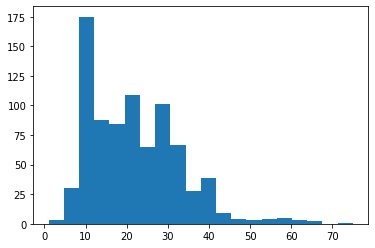

In [115]:
textStatistics(pharma_medication, "medication")
print([feature for feature in pharma_medication["medication"] if len(feature)<5])
print([feature for feature in pharma_medication["medication"] if len(feature)>70])


### **<u>inputevents (MIMIC_IV ICU)</u>** (_icu_ module)

_inputevents_: **10 953 713** rows
Contains **76 510** distinct (`subject_id`, `hadm_id`)

1) <u>integrity</u>
- There are **8 732** (`subject_id`, `hadm_id`) that don't have any input events associated data
- There are no errors in the (`subject_id`, `hadm_id`) referenced in _inputevents_.
- 10 rows with `starttime` > `endtime`

2) <u>counts</u> 
none of `subject_id`, `hadm_id` or `stay_id` is ever null 
- number of inputevent rows per (`subject_id`, `hadm_id`)
- (_from result of previous query_) average number of input events rows per (`subject_id`, `hadm_id`) **143.17**, ranging from **1** to **13 107**

3) <u>null values</u>
- `starttime`, `endtime`, `itemid`, `amount`, `amountuom` are never null ; `statusdescription`, `originalamount`, `originalrate` either
- **4897231** of the rows have null `rate`, **4897231** have null `rateuom` (there are always null on the same rows)

In [ ]:
% sql

# first we select all subject_id-hadm_id pairs in inputsevents
SELECT subject_id, hadm_id, COUNT(*) 
FROM `physionet-data.mimiciv_3_1_icu.inputevents`
GROUP BY subject_id, hadm_id

# then with result from previous query
# we look at the patient admission with no inputevents data
SELECT COUNT(*) 
FROM `iame-int.ICU.patientICUstays` P
LEFT JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon9c8cd8b717c152f721410b03f0ea1f677b7e35b641629b0472f484bbdde98d07` I
ON P.subject_id=I.subject_id AND P.hadm_id=I.hadm_id
WHERE I.subject_id IS NULL

# coherence check query on time
SELECT * FROM `physionet-data.mimiciv_3_1_icu.inputevents`
WHERE starttime > endtime